## Preparation Datasets

In [1]:
! pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="8a1TnuwmOs3C6u2D0OAx")
project = rf.workspace("thesiscv").project("coffee-quality-qdwbi")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coffee-Quality-1 in folder:: 100%|██████████| 5033/5033 [00:00<00:00, 7516.06it/s]


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
train_dir = '/content/Coffee-Quality-1/train'
test_dir = '/content/Coffee-Quality-1/test'
val_dir = '/content/Coffee-Quality-1/valid'

In [5]:
label = []
count = []
for dir in os.listdir(train_dir):
  label.append(dir)
  count.append(len(os.listdir(f'/content/Coffee-Quality-1/train/{dir}')))

fig = px.bar(x=label, y=count, title="Jumlah Data pada Kategori")
fig.show()

In [6]:
label = []
count = []
for dir in os.listdir(test_dir):
  label.append(dir)
  count.append(len(os.listdir(f'/content/Coffee-Quality-1/test/{dir}')))

fig = px.bar(x=label, y=count, title="Jumlah Data pada Kategori")
fig.show()

In [7]:
label = []
count = []
for dir in os.listdir(val_dir):
  label.append(dir)
  count.append(len(os.listdir(f'/content/Coffee-Quality-1/valid/{dir}')))

fig = px.bar(x=label, y=count, title="Jumlah Data pada Kategori")
fig.show()

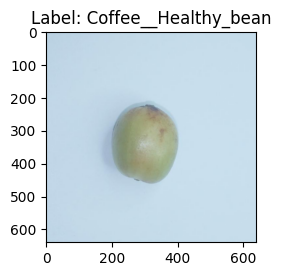

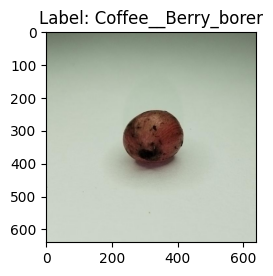

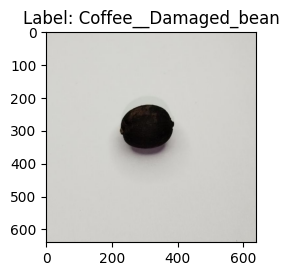

In [8]:
def show_images(image_dir, label, num_images=1):
    # Filter images by label
    images = []
    labels = []

    for dir in os.listdir(test_dir):
        if dir == label:
            for filename in os.listdir(os.path.join(image_dir, dir)):
                img_path = os.path.join(image_dir, dir, filename)
                images.append(img_path)
                labels.append(dir)

    # Display images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 2, i + 1)
        img = Image.open(images[i])
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")

show_images(train_dir, 'Coffee__Healthy_bean')
show_images(test_dir, 'Coffee__Berry_borer')
show_images(test_dir, 'Coffee__Damaged_bean')

## Preprocessing datasets

In [9]:
def preprocessing(image_dir, display_crop=False):
    images = []
    labels = []

    # Loop through each subdirectory (label) in the given directory
    for label in os.listdir(image_dir):
        label_path = os.path.join(image_dir, label)

        # Ensure it's a directory
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)

                try:
                    # Load image
                    img = Image.open(img_path)

                    # Get image dimensions
                    width, height = img.size

                    # Define crop box (central 25-75%)
                    left = int(0.25 * width)
                    right = int(0.75 * width)
                    top = int(0.25 * height)
                    bottom = int(0.75 * height)
                    img_cropped = img.crop((left, top, right, bottom))

                    # if display_crop:
                    #     plt.imshow(img_cropped)
                    #     plt.title(f"Cropped Image: {label}")
                    #     plt.axis('off')
                    #     plt.show()
                    #     display_crop = False

                    # Resize image
                    img_resized = img_cropped.resize((240, 240))

                    # Convert to array and add to list
                    img_array = img_to_array(img_resized)
                    images.append(img_array)
                    labels.append(label)

                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    # print(labels)
    # Convert list to numpy array
    X = np.array(images, dtype='float32') / 255.0  # Normalize pixel values
    y = LabelEncoder().fit_transform(labels)
    # print("LABEL ENCODER")
    # print(y)
    y = to_categorical(y)
    # print("CATEGORICAL")
    # print(y)

    return X, y

In [10]:
X_train, y_train = preprocessing(train_dir, display_crop=True)
X_test, y_test = preprocessing(test_dir, display_crop=False)
X_val, y_val = preprocessing(val_dir, display_crop=False)

In [11]:
print("Train data:", X_train.shape)
print("Train label:", y_train.shape)
print("Test data:", X_test.shape)
print("Test label:", y_test.shape)

Train data: (4389, 240, 240, 3)
Train label: (4389, 3)
Test data: (210, 240, 240, 3)
Test label: (210, 3)


In [12]:
print("Train data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (4389, 240, 240, 3) (4389, 3)
Test data shape: (210, 240, 240, 3) (210, 3)


## Model

In [13]:
def cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
input_shape = (240, 240, 3)
num_classes = 3

model = cnn_model(input_shape, num_classes)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# history = model.fit(X_train, y_train,
#                     epochs=15, batch_size=32,
#                     validation_data=(X_val, y_val))

In [16]:
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

In [17]:
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label = 'val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

## Performance Checking

In [18]:
from sklearn.metrics import classification_report

# y_pred = model.predict(X_test)

# y_pred_classes = np.argmax(y_pred, axis=1)

# if y_test.ndim > 1:
#     y_true = np.argmax(y_test, axis=1)
# else:
#     y_true = y_test

# report = classification_report(y_true, y_pred_classes)
# print(report)

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
def plot_confusion_matrix(model, X_test, y_test, class_names):
    """
    Plot confusion matrix based on model predictions and true labels.

    Parameters:
    - model: Trained model
    - X_test: Test dataset features
    - y_test: Test dataset labels (one-hot encoded)
    - class_names: List of class names
    """
    # Predict classes for test data
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
    y_true = np.argmax(y_test, axis=1)        # Convert one-hot encoded labels to class indices

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [21]:
# # Daftar nama kelas
# class_names = ['Coffee Damage Bean', 'Coffee Healthy Berry', 'Coffee Berry Borer']

# # Memanggil fungsi untuk confusion matrix
# plot_confusion_matrix(model, X_test, y_test, class_names)

## Artificial Bee Colony


Artificial Bee Colony
---



In [22]:
def create_cnn_model(params, input_shape=(240, 240, 3), num_classes=3):

    """

    Create and return a CNN model with the specified hyperparameters

    """

    model = models.Sequential()
    # Initial convolutional layer
    model.add(layers.Conv2D(params['filters'],
                     (params['kernel_size'], params['kernel_size']),
                     activation='relu',
                     input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Additional convolutional layers
    for _ in range(params['conv_layers'] - 1):
        model.add(layers.Conv2D(params['filters'],
                        (params['kernel_size'], params['kernel_size']),
                        activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(params['dense_units'], activation='relu'))
    model.add(layers.Dropout(params['dropout_rate']))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
    """
    Train the model and return the validation accuracy
    """
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=0
    )

    return history.history['val_accuracy'][-1]

In [23]:
import gc
import random


# CNN Model Function (separate from ABC)
class ArtificialBeeColony:

    def __init__(self, param_bounds, colony_size=20, max_iterations=5):

        """
        Initialize ABC optimizer
        param_bounds: dictionary of parameter bounds in the format:

            {
                'param_name': (lower_bound, upper_bound)
            }

        """
        self.param_bounds = param_bounds
        self.colony_size = colony_size
        self.max_iterations = max_iterations
        self.food_sources = []
        self.fitness_values = []
        self.trials = np.zeros(colony_size)
        self.limit = colony_size * len(param_bounds)

    def initialize_population(self):

        """Initialize random solutions within the parameter bounds"""

        self.food_sources = []
        for _ in range(self.colony_size):
            solution = {}
            for param, (lower, upper) in self.param_bounds.items():
                if isinstance(lower, int) and isinstance(upper, int):
                    solution[param] = random.randint(lower, upper)
                else:
                    solution[param] = random.uniform(lower, upper)
            self.food_sources.append(solution)
        self.fitness_values = [0] * self.colony_size

    def generate_neighbor_solution(self, solution):

        """Generate a neighboring solution by modifying one parameter"""

        new_solution = solution.copy()
        param_to_modify = random.choice(list(self.param_bounds.keys()))
        lower, upper = self.param_bounds[param_to_modify]

        if isinstance(lower, int) and isinstance(upper, int):
            new_solution[param_to_modify] = random.randint(lower, upper)
        else:
            new_solution[param_to_modify] = random.uniform(lower, upper)

        return new_solution

    def optimize(self, fitness_function):
        """
        Main ABC optimization loop
        fitness_function: function that takes a solution and returns its fitness
        """

        self.initialize_population()
        best_solution = None
        best_fitness = float('-inf')

        # Calculate initial fitness values
        for i in range(self.colony_size):
            self.fitness_values[i] = fitness_function(self.food_sources[i])
            if self.fitness_values[i] > best_fitness:
                best_fitness = self.fitness_values[i]
                best_solution = self.food_sources[i].copy()

        # Main ABC loop
        for iteration in range(self.max_iterations):
            print(f"Iteration {iteration + 1}/{self.max_iterations}")

            # Employed Bee Phase
            for i in range(self.colony_size):
                neighbor = self.generate_neighbor_solution(self.food_sources[i])
                neighbor_fitness = fitness_function(neighbor)

                if neighbor_fitness > self.fitness_values[i]:
                    self.food_sources[i] = neighbor
                    self.fitness_values[i] = neighbor_fitness
                    self.trials[i] = 0
                else:
                    self.trials[i] += 1

            # Onlooker Bee Phase
            probabilities = self.fitness_values / np.sum(self.fitness_values)
            for i in range(self.colony_size):
                if random.random() < probabilities[i]:
                    neighbor = self.generate_neighbor_solution(self.food_sources[i])
                    neighbor_fitness = fitness_function(neighbor)
                    if neighbor_fitness > self.fitness_values[i]:
                        self.food_sources[i] = neighbor
                        self.fitness_values[i] = neighbor_fitness
                        self.trials[i] = 0
                    else:
                        self.trials[i] += 1

            # Scout Bee Phase
            for i in range(self.colony_size):
                if self.trials[i] > self.limit:
                    new_solution = {}
                    for param, (lower, upper) in self.param_bounds.items():
                        if isinstance(lower, int) and isinstance(upper, int):
                            new_solution[param] = random.randint(lower, upper)
                        else:
                            new_solution[param] = random.uniform(lower, upper)
                    self.food_sources[i] = new_solution
                    self.fitness_values[i] = fitness_function(new_solution)
                    self.trials[i] = 0


            # Update best solution

            current_best = max(self.fitness_values)
            if current_best > best_fitness:
                best_fitness = current_best
                best_solution = self.food_sources[
                    self.fitness_values.index(current_best)
                ].copy()

            # Print results for this iteration
            print(f"Iteration {iteration + 1} - Best fitness: {best_fitness}")
            print(f"Best parameters in iteration {iteration + 1}: {best_solution}")
            print(f"Best fitness so far: {best_fitness}")

        return best_solution, best_fitness


def main():
    # Define parameter bounds
    param_bounds = {
        'learning_rate': (0.0001, 0.01),
        'conv_layers': (2, 3),
        'filters': (32, 128),
        'kernel_size': (2, 5),
        'dense_units': (64, 128),
        'dropout_rate': (0.1, 0.5)
    }

    # Initialize ABC optimizer
    abc = ArtificialBeeColony(
        param_bounds=param_bounds,
        colony_size=20,
        max_iterations=5
    )

    # Define fitness function that uses your data
    def fitness_function(params):
        """
        Create and evaluate a CNN model with the given parameters
        """

        # Replace X_train, y_train, X_val, y_val with your actual data
        model = create_cnn_model(params)
        fitness = train_and_evaluate(model, X_train, y_train, X_test, y_test, batch_size=16)

        del model
        gc.collect()

        return fitness

    # Run optimization
    best_params, best_fitness = abc.optimize(fitness_function)
    print("Optimization completed!")
    print("Best parameters found:", best_params)
    print("Best validation accuracy:", best_fitness)



if __name__ == "__main__":
    main()

Iteration 1/5
Iteration 1 - Best fitness: 0.9428571462631226
Best parameters in iteration 1: {'learning_rate': 0.002725109582072563, 'conv_layers': 3, 'filters': 34, 'kernel_size': 3, 'dense_units': 72, 'dropout_rate': 0.4137302348718349}
Best fitness so far: 0.9428571462631226
Iteration 2/5
Iteration 2 - Best fitness: 0.9428571462631226
Best parameters in iteration 2: {'learning_rate': 0.002725109582072563, 'conv_layers': 3, 'filters': 34, 'kernel_size': 3, 'dense_units': 72, 'dropout_rate': 0.4137302348718349}
Best fitness so far: 0.9428571462631226
Iteration 3/5
Iteration 3 - Best fitness: 0.9428571462631226
Best parameters in iteration 3: {'learning_rate': 0.002725109582072563, 'conv_layers': 3, 'filters': 34, 'kernel_size': 3, 'dense_units': 72, 'dropout_rate': 0.4137302348718349}
Best fitness so far: 0.9428571462631226
Iteration 4/5
Iteration 4 - Best fitness: 0.9714285731315613
Best parameters in iteration 4: {'learning_rate': 0.0008281090288727839, 'conv_layers': 3, 'filters': 